In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from matplotlib import pyplot as plot
import time

In [3]:
dir_name = os.getcwd()
batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

100%|██████████| 170498071/170498071 [00:02<00:00, 70407174.33it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [4]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

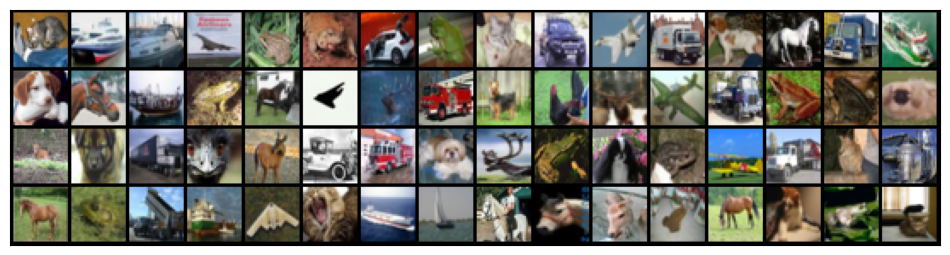

In [5]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plot.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(test_data_loader)

In [29]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.model = torch.nn.Sequential(
    # 3x32x32 -> 16x((32-3)/1+1)x((32-3)/1+1) = 16x30x30
    torch.nn.Conv2d(3, 16, 3),
    # 15x30x30
    torch.nn.ReLU(),
    # 16x30x30 -> 16x((30-2)/2+1)x((30-2)/2+1) = 16x15x15
    torch.nn.MaxPool2d(2,2),
    # 16x15x15 -> 64x((15-3)+1)x((15-3)+1) = 64x13x13
    torch.nn.Conv2d(16, 64, 3),
    # 64x13x13
    torch.nn.ReLU(),
    # 64x13x13 -> 64x((13-2-1)/2+1)x((13-2-1)/2+1) = 64x6x6
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(64*6*6, 10))

  def forward(self, x):
    return self.model(x)

cnn = CNN()
cnn

CNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2304, out_features=10, bias=True)
  )
)

In [32]:
learning_rate = 0.1
num_epochs = 60

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_time = time.time() - start
    if epoch % 10 == 0:
        print('Epoch[{}]: accuracy = {}'.
              format(epoch, get_accuracy(train_data_loader, cnn)))
        print(f'    epoch_time = {int(epoch_time // 60)} min, {int(epoch_time % 60)} sec')

Epoch[0]: accuracy = 0.7300199866294861
    epoch_time = 0 min, 36 sec
Epoch[10]: accuracy = 0.7961000204086304
    epoch_time = 0 min, 36 sec
Epoch[20]: accuracy = 0.6795399785041809
    epoch_time = 0 min, 34 sec
Epoch[30]: accuracy = 0.8105400204658508
    epoch_time = 0 min, 36 sec
Epoch[40]: accuracy = 0.7831599712371826
    epoch_time = 0 min, 34 sec
Epoch[50]: accuracy = 0.8077200055122375
    epoch_time = 0 min, 34 sec


In [33]:
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, cnn)))

Test accuracy: 0.6384999752044678
